### Exploring increasing the number of samples

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt
import seaborn as sns
import pandas as pd

In [2]:
in_domain_results = os.listdir("../results/cross_validated_results/in_domain_extra_sample_results")

In [3]:
in_domain_results = [i for i in in_domain_results if "individual_stats" in i]

In [4]:
SAMPLING_UNCERTAINTY_TYPES = {
    "MC-Drop",
    "Ens",
    "Ind",
    "P-Unet",
    "SSN",
    "SSN-Ens",
}

In [5]:
def convert_files_to_large_df(folder, filenames):
    dfs = []
    for fn in filenames:
        df = pd.read_csv(os.path.join(folder, fn))
        if "_evidential_b" in fn:
            uncertainty_type = "Evid"
        elif "_deterministic_b" in fn:
            uncertainty_type = "SEnt"
        elif "_ind_b" in fn:
            uncertainty_type = "Ind"
        elif "_punet_b" in fn:
            uncertainty_type = "P-Unet"
        elif "_ens_b" in fn and "ssn" not in fn:
            uncertainty_type = "Ens"
        elif "_mc_drop_b" in fn:
            uncertainty_type = "MC-Drop"
        elif "_ssn_ens_b" in fn:
            uncertainty_type = "SSN-Ens"
        elif "_ssn_b" in fn:
            uncertainty_type = "SSN"
        else:
            print("uncertainty type unclear for ", fn)
            continue
            
        cv_fold = fn.split("_")[-3][-1]
        
        df['uncertainty_type'] = [uncertainty_type for _ in range(len(df))]
        df['cv_fold'] = [cv_fold for _ in range(len(df))]
        
        dfs.append(df)
    
    return pd.concat(dfs, ignore_index=False)

In [6]:
from scipy.stats import t as t_distribution
def mean_and_95_conf_over_cvfold(df, metric, return_sem=True):
    cv_scores = df.groupby(['uncertainty_type', 'cv_fold'])[metric].mean().groupby('uncertainty_type')
    mean = cv_scores.mean().rename(f"{metric} mean", axis='index')
    std = cv_scores.std(ddof=1)
    size = cv_scores.size()
    sem_value = std / (np.sqrt(size))
    
    confidence_level = 0.95
    degrees_of_freedom = size - 1
    margin_of_error = t_distribution.ppf((1 + confidence_level) / 2, degrees_of_freedom) * sem_value
    margin_of_error = margin_of_error.rename(f"{metric} 95%")
    sem_value  = sem_value.rename(f"{metric} 95%")
    confidence_interval = (mean - margin_of_error, mean + margin_of_error)
    
    if return_sem:
        return pd.concat([mean, sem_value], axis=1)#, confidence_interval[0], confidence_interval[1]], axis=1)
    else:
        return pd.concat([mean, margin_of_error], axis=1)

In [7]:
in_domain_df = convert_files_to_large_df("../results/cross_validated_results/in_domain_extra_sample_results", in_domain_results)

In [8]:
in_domain_df

,Unnamed: 0,gt_vols,best_dice_ss2,best_avd_ss2,best_dice_dsorted_ss2,GED^2_ss2,sUEO_ss2,best_dice_ss3,best_avd_ss3,best_dice_dsorted_ss3,...,GED^2_ss25,sUEO_ss25,best_dice_ss30,best_avd_ss30,best_dice_dsorted_ss30,GED^2_ss30,sUEO_ss30,model_name,uncertainty_type,cv_fold
0,0,2290.0,0.432481,53.187775,0.434316,1.408246,0.472057,0.433749,53.013100,0.437090,...,1.421305,0.472060,0.437926,52.401745,0.442925,1.423469,0.472055,ind_cv1,Ind,1
1,1,19229.0,0.857297,7.254668,0.857721,0.487028,0.496845,0.857035,7.244267,0.857837,...,0.491527,0.496845,0.857366,7.015445,0.859001,0.491369,0.496844,ind_cv1,Ind,1
2,2,3486.0,0.594875,39.902466,0.596699,1.132065,0.428355,0.595683,39.644290,0.597883,...,1.138835,0.428350,0.596892,39.386116,0.600358,1.138947,0.428353,ind_cv1,Ind,1
3,3,1738.0,0.547804,43.153050,0.551546,1.208934,0.443709,0.552053,43.037975,0.554004,...,1.222011,0.443711,0.553207,42.117374,0.558327,1.221870,0.443707,ind_cv1,Ind,1
4,4,27193.0,0.884030,1.849741,0.884486,0.401710,0.494223,0.884392,1.732063,0.885111,...,0.405637,0.494233,0.884821,1.537160,0.885863,0.405365,0.494227,ind_cv1,Ind,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37,37,40014.0,0.789796,16.409258,0.790700,0.662176,0.462248,0.789955,16.321787,0.791099,...,0.671859,0.462235,0.790253,16.179337,0.792207,0.671899,0.462231,ind_cv4,Ind,4
38,38,18296.0,0.803624,9.942063,0.804784,0.623279,0.515545,0.803510,9.980324,0.804326,...,0.631174,0.515596,0.804430,9.482947,0.806807,0.631288,0.515596,ind_cv4,Ind,4
39,39,5409.0,0.750297,12.978369,0.751064,0.780363,0.484402,0.750642,12.867443,0.752252,...,0.784081,0.484405,0.751133,12.349788,0.754082,0.785000,0.484399,ind_cv4,Ind,4
40,40,15651.0,0.857172,14.618874,0.857803,0.475834,0.509376,0.857477,14.491087,0.858286,...,0.482979,0.509379,0.858520,14.254681,0.860056,0.482424,0.509373,ind_cv4,Ind,4


In [9]:
pd.set_option('display.float_format',
      lambda x: '{:,.3f}'.format(x) if abs(x) < 10000 else '{:,.0f}'.format(x))

In [10]:
dfs = []
for key in ["best_dice_dsorted_ss10"]:
    dfs.append(mean_and_95_conf_over_cvfold(in_domain_df, key, return_sem=False))
standard_metrics_df = pd.concat(dfs, axis=1)
standard_metrics_df.to_csv("in_domain_best_dice_sample_sorted_stats.csv")
standard_metrics_df

,best_dice_dsorted_ss10 mean,best_dice_dsorted_ss10 95%
uncertainty_type,,
Ens,0.705,0.029
Ind,0.668,0.026
MC-Drop,0.697,0.027
P-Unet,0.675,0.023
SSN,0.716,0.023
SSN-Ens,0.731,0.025


In [11]:
standard_metrics_df['best_dice_dsorted_ss10 mean']

uncertainty_type
Ens       0.705
Ind       0.668
MC-Drop   0.697
P-Unet    0.675
SSN       0.716
SSN-Ens   0.731
Name: best_dice_dsorted_ss10 mean, dtype: float64

In [12]:
import matplotlib.cm as cm 
cmap = cm.Set2
UNCERTAINTY_COLOURS = {
    'Ens':'blue5',
    'Evid':'black',
    'Ind':'teal5',
    'MC-Drop':'pink5',
    'P-Unet':'lime5',
    'SEnt':'blue',
    'SSN':'gray5',
    'SSN-Ens':'orange5',
}

In [13]:
from collections import defaultdict
from scipy.stats import t as t_distribution


In [38]:
def plot_metric_as_samples_increase(ax, df, metric, ylabel, title, dolegend, ylim=None, xlim=None):
    metric_vals = {}
    sample_nums = [2,3,5,7,10,15,20,25,30]

    dataset_averages = df.groupby(['uncertainty_type', 'cv_fold'])[[f'{metric}_ss{s}' for s in sample_nums]].mean().groupby(['uncertainty_type'])
    mean_score = dataset_averages.mean()
    std = dataset_averages.std()
    size = 6#dataset_averages.size()

    sem_value = std / (np.sqrt(size))
    confidence_level = 0.95
    degrees_of_freedom = size - 1
    # margin_of_error = t_distribution.ppf((1 + confidence_level) / 2, degrees_of_freedom) * sem_value

    hs = []
    for key in SAMPLING_UNCERTAINTY_TYPES:
        h = ax.scatter(sample_nums, mean_score.loc[key].values, label=key, zorder=3, color=UNCERTAINTY_COLOURS[key])
        ax.errorbar(sample_nums, mean_score.loc[key].values, yerr= sem_value.loc[key].values,
                     color=UNCERTAINTY_COLOURS[key], capsize=5, linestyle='--', linewidth=2)
        hs.append(h)
    
    if dolegend:
        ax.legend(loc='upper right');

    ax.set_xlabel("Number of Samples")
    ax.set_ylabel(ylabel)
    
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    
    # plt.legend(['Line']) 
    ax.set_title(title)
    
    return hs

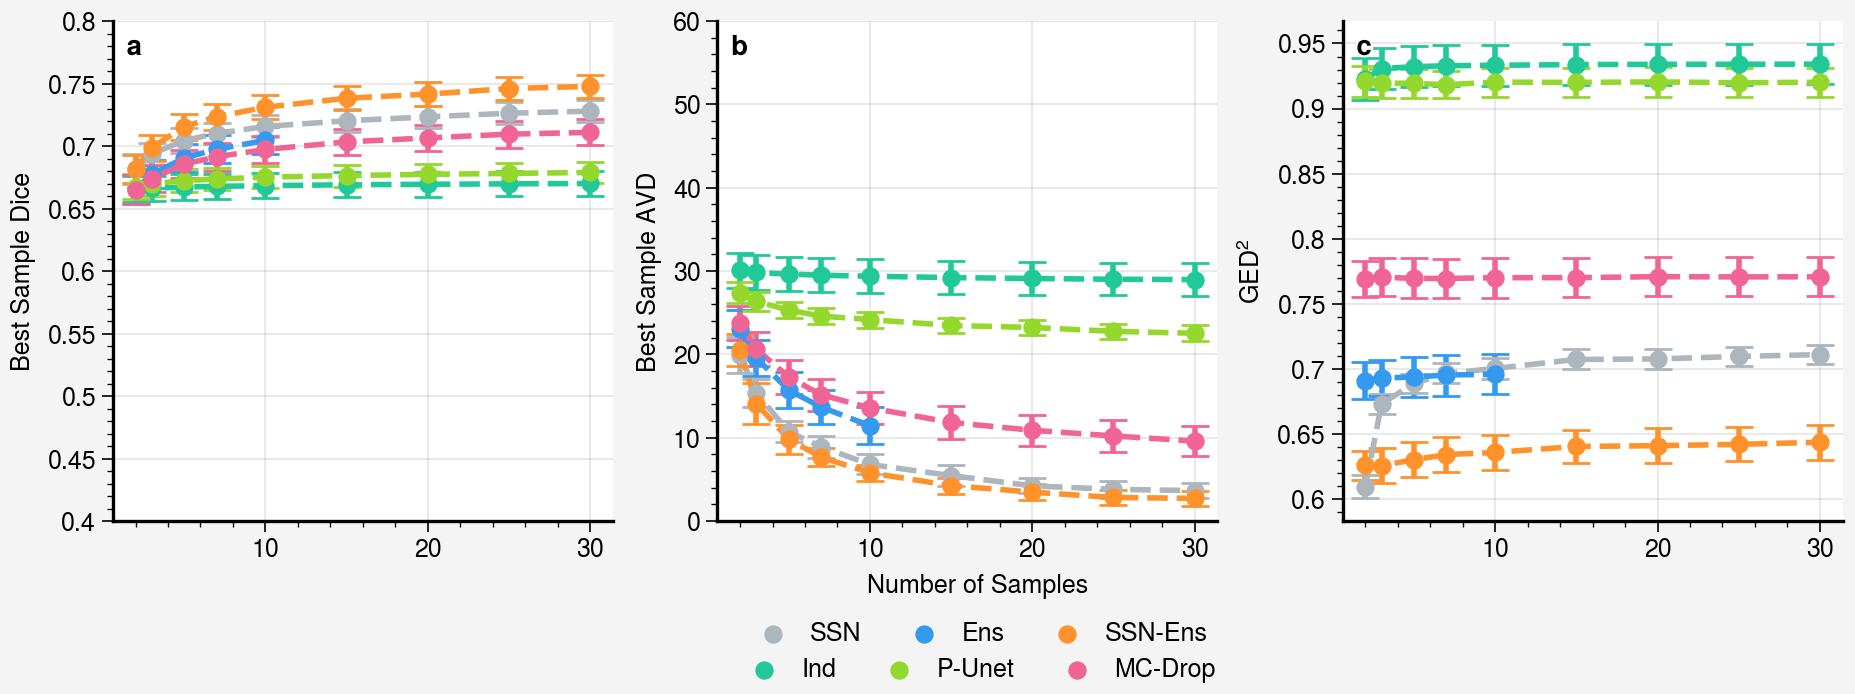

In [39]:
fig = pplt.figure(refwidth="20em", span=True, share=False)
axs = fig.subplots(nrows=1, ncols=3)
axs.format(abc=True, abcloc='ul', suptitle="", xlabel=r"Number of Samples", grid=True)

plot_metric_as_samples_increase(axs[0], in_domain_df, "best_dice_dsorted", r"Best Sample Dice", "", False, ylim=(0.4, 0.8))
plot_metric_as_samples_increase(axs[1], in_domain_df, "best_avd", r"Best Sample AVD", "", False, ylim=(0, 60))
hs = plot_metric_as_samples_increase(axs[2], in_domain_df, "GED^2", r"$GED^2$", "", False)

for ax in axs:
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_linewidth(1.2)  # Thicker bottom spine
    ax.spines['left'].set_linewidth(1.2)  # Thicker left spine

fig.legend(hs, center=True, frame=False, loc='b')
fig.save(f"plots_output/MIUA_increasing_sample_num_plot.pdf")

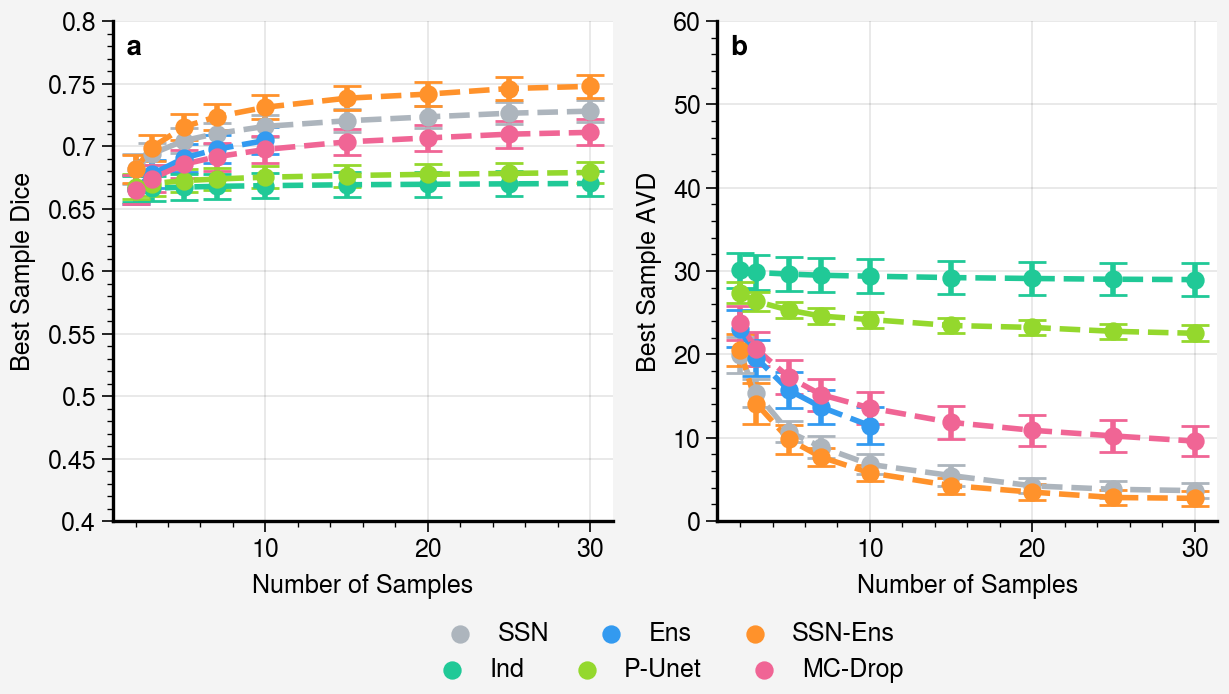

In [40]:
fig = pplt.figure(refwidth="20em", span=False, share=False)
axs = fig.subplots(nrows=1, ncols=2)
axs.format(abc=True, abcloc='ul', suptitle="", xlabel=r"Number of Samples", grid=True)

plot_metric_as_samples_increase(axs[0], in_domain_df, "best_dice_dsorted", r"Best Sample Dice", "", False, ylim=(0.4, 0.8))
hs = plot_metric_as_samples_increase(axs[1], in_domain_df, "best_avd", r"Best Sample AVD", "", False, ylim=(0, 60))

for ax in axs:
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_linewidth(1.2)  # Thicker bottom spine
    ax.spines['left'].set_linewidth(1.2)  # Thicker left spine
    
fig.legend(hs, center=True, frame=False, loc='b')
fig.save(f"plots_output/MIUA_WITHOUT_GED_increasing_sample_num_plot.pdf")

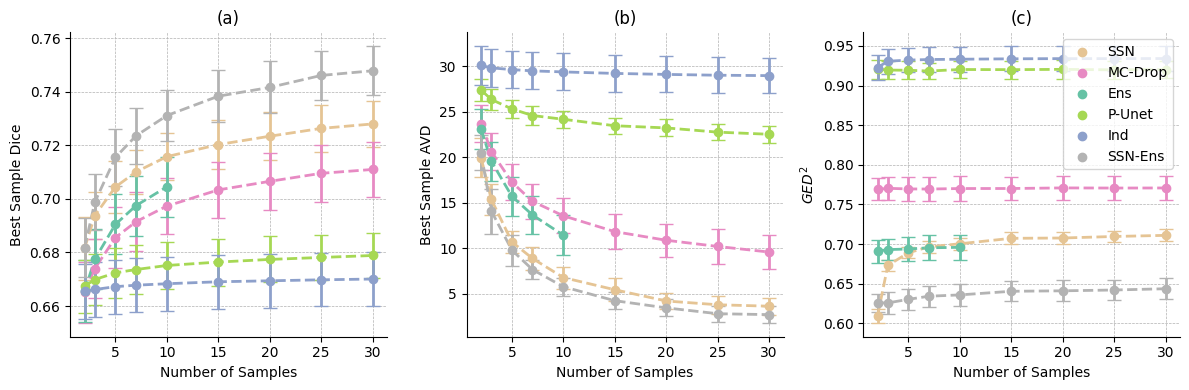

In [13]:
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plot_metric_as_samples_increase(in_domain_df, "best_dice_dsorted", r"Best Sample Dice", "(a)", False)
plt.subplot(1,3,2)
plot_metric_as_samples_increase(in_domain_df, "best_avd", r"Best Sample AVD", "(b)", False)
plt.subplot(1,3,3)
plot_metric_as_samples_increase(in_domain_df, "GED^2", r"$GED^2$", "(c)", True)

plt.tight_layout()
plt.savefig("plots_output/increasing_sample_num_plot.pdf", bbox_inches="tight")

In [50]:
margin_of_error

,best_avd_ss2,best_avd_ss3,best_avd_ss5,best_avd_ss7,best_avd_ss10,best_avd_ss15,best_avd_ss20,best_avd_ss25,best_avd_ss30
uncertainty_type,,,,,,,,,
Ens,5.722251,5.497710,5.593421,5.305655,5.646043,NaN,NaN,NaN,NaN
Ind,5.451732,5.278979,5.227954,5.217156,5.222398,5.121281,5.079315,5.015354,5.014117
MC-Drop,5.252105,5.235049,5.159455,4.909893,4.921788,4.984549,4.727297,4.991867,4.747354
P-Unet,3.194817,2.954604,2.586056,2.562870,2.479734,2.315445,2.402762,2.301648,2.428721
SSN,5.547337,4.368766,3.203798,3.354275,3.105478,3.198758,2.348717,2.555407,2.361789
SSN-Ens,4.943625,6.344145,4.379807,2.770161,2.520664,2.462456,2.389692,2.313378,2.330791


In [27]:
mean_score.loc['Ens']

GED^2_ss2     0.691047
GED^2_ss3     0.693040
GED^2_ss5     0.693811
GED^2_ss7     0.695330
GED^2_ss10    0.695895
GED^2_ss15         NaN
GED^2_ss20         NaN
GED^2_ss25         NaN
GED^2_ss30         NaN
Name: Ens, dtype: float64

In [15]:
in_domain_df.keys()

Index(['Unnamed: 0', 'gt_vols', 'best_dice_ss2', 'best_avd_ss2',
       'best_dice_dsorted_ss2', 'GED^2_ss2', 'sUEO_ss2', 'best_dice_ss3',
       'best_avd_ss3', 'best_dice_dsorted_ss3', 'GED^2_ss3', 'sUEO_ss3',
       'best_dice_ss5', 'best_avd_ss5', 'best_dice_dsorted_ss5', 'GED^2_ss5',
       'sUEO_ss5', 'best_dice_ss7', 'best_avd_ss7', 'best_dice_dsorted_ss7',
       'GED^2_ss7', 'sUEO_ss7', 'best_dice_ss10', 'best_avd_ss10',
       'best_dice_dsorted_ss10', 'GED^2_ss10', 'sUEO_ss10', 'best_dice_ss15',
       'best_avd_ss15', 'best_dice_dsorted_ss15', 'GED^2_ss15', 'sUEO_ss15',
       'best_dice_ss20', 'best_avd_ss20', 'best_dice_dsorted_ss20',
       'GED^2_ss20', 'sUEO_ss20', 'best_dice_ss25', 'best_avd_ss25',
       'best_dice_dsorted_ss25', 'GED^2_ss25', 'sUEO_ss25', 'best_dice_ss30',
       'best_avd_ss30', 'best_dice_dsorted_ss30', 'GED^2_ss30', 'sUEO_ss30',
       'model_name', 'uncertainty_type', 'cv_fold'],
      dtype='object')

In [ ]:
### we need to do a plot for: ged, best dice sorted, best avd, thats it. Nice.